# Analysis of Hanly & Tubbs Fires

In [1]:
### add commercial

In [2]:
## Import packages
import os
import requests
import pandas as pd
import json
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely.geometry
import contextily as cx
import xarray as xr
#import urllib
import netCDF4
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display
from shapely.ops import transform

/usr/local/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [3]:
hdf = pd.read_csv("/Users/27249/Desktop/GitRepos/HanlyTubbsVoilaHeroku/Data/PSQL_SonomaCountyHousing.csv")

In [4]:
#export_csv = hdf.to_csv("/Users/27249/Desktop/GitRepos/HanlyTubbsVoilaHeroku/Data/PSQL_SonomaCountyHousing.csv")

In [5]:
## function to take CSV file from github
import pandas as pd

def read_file(url):

    """
    Takes GitHub url as an argument,
    pulls CSV file located @ github URL.

    """

    url = url + "?raw=true"
    df = pd.read_csv(url)
    return df

In [6]:
## function to take shape files from github

def gpd_read_file(url):

    """
    Takes GitHub url as an argument,
    pulls shape files located @ github URL.

    """

    url = url #+ "?raw=true"
    df = gpd.read_file(url)
    return df

In [7]:
#son = pd.read_csv("/Users/27249/Desktop/GitRepos/HanlyTubbsFires/02_Data/Sonoma_092017.csv")

In [8]:
#son.head()

In [9]:
## Set variables to read files

data_url = "https://github.com/hollifknight/HanlyTubbsVoilaHeroku/"

housing_url = data_url+"/blob/master/Data/SonomaWithLatLong.csv"
weather_url = data_url+"/blob/master/Data/weather_master.csv"
census_url = data_url+ "raw/master/Data/tl_2017_06_bg.zip"
psql_url = data_url+''

In [10]:
## Fire Maps

In [11]:
def UrlToDf(url):
    ## Use requests package to access API
    request = requests.get(url)
    
    ## Convert to JSON
    data = request.json()
    
    ## Select feature set
    features = data['features']
    
    ## Normalize and convert to DataFrame
    df = pd.DataFrame(pd.json_normalize(features))
    
    return df


url_1960s = "https://egis.fire.ca.gov/arcgis/rest/services/FRAP/FirePerimeters/MapServer/7/query?where=1%3D1&outFields=*&outSR=4326&f=json"
df60 = UrlToDf(url_1960s)

url_2010s = "https://egis.fire.ca.gov/arcgis/rest/services/FRAP/FirePerimeters/MapServer/2/query?where=1%3D1&outFields=*&outSR=4326&f=json"
df10 = UrlToDf(url_2010s)




In [12]:
## Append datasets & select fires of interest
df_append = df60.append(df10)
fire_df = df_append.loc[(df_append['attributes.FIRE_NAME'] == "C. HANLY") | 
                        (df_append['attributes.FIRE_NAME'] == 'TUBBS')]


/var/folders/lk/ty0zvm7x1711sth69gl25hsr0000gr/T/ipykernel_24732/3250965773.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_append = df60.append(df10)


In [13]:
def MakeGeo(df, geo_column, shape, spacial_ref):
    ## inputs: dataframe, initial geometry column, shapely geometry, and geometry spacial reference
    
    ## Reset index for joining data
    df = df.reset_index()
    
    ## Unstack nested list in Esri Geometry Column 
    df_geometry = df[geo_column]
    df = df.join(pd.DataFrame(df_geometry.apply(pd.Series).stack()).reset_index())
    
    ## Rename new column
    df.columns = [*df.columns[:-1], 'geom']
    ## Tranform column to list of tuples (required for polygon data)
    df['geom'] = list(tuple(x) for x in df['geom'])
    
    ## Create geometry by calling shapely.geometry
    df['geometry'] = df.apply(lambda row: shape(row['geom']), axis=1)
    
    ## Drop unnecessary column
    df = df.drop(columns = ['level_0', 'level_1', 'geom'])
    
    ## Set geometry column and specify the geometry's spacial reference
    gdf = df.set_geometry("geometry", crs = spacial_ref)
    ## Return GeoDataFrame
    return gdf


fire_gdf = MakeGeo(fire_df, 'geometry.rings', shapely.geometry.Polygon, "EPSG:4326")


In [14]:
## Housing Data

In [15]:
##original geo processing 

#df = pd.read_excel("/Users/27249/Downloads/Excel_Master_Secured September 2017.xlsx")

#df['Address'] = df['Situs:Formatted1'] + ' ' + df['Situs:Formatted2']
        
#from geopy.geocoders import Nominatim
#locator = Nominatim(user_agent="hollifknight@gmail.com", timeout=10)

#half = int(len(df)/2)
#df1 = df.iloc[0:half, :]
#df2 = df.iloc[half:len(df), :]


#df1['GeoLocation'] = df1['Address'].apply(locator.geocode)
#df2['GeoLocation'] = df2['Address'].apply(locator.geocode)

#df = df1.append(df2)

#df = df.drop(columns = ['Book', 'SecuredAsmt','LowValue','AsmtStatus','AsmtStatusDate', 
#                        'AsmtDescription', 'AsmtComments', 'UnsecAsmtDesc', 'CurrentDocNum', 
#                        'CurrentDocDate', 'CurrentOwnerName','Taxability','TaxabilityFull'])

#data = df.copy()
#data = data.loc[data['GeoLocation'].notna()]
#data= data.reset_index(drop=True)

#geometry = []
#latlong = []
#for address, coords in data['GeoLocation']:
#    point = shapely.geometry.Point(coords)
#    geometry.append(point)
#    latlong.append(coords)

#data = data.join(pd.DataFrame(geometry, columns=["geom"]))
#data = data.join(pd.DataFrame(latlong, columns = ['Lat', 'Long']))

#data = data[(data['Long'] < -122) & (data['Lat'] < 39) & (data['Lat'] > 38)]
#gdf = data.set_geometry("geom")

#gdf['geom'] = gdf.geometry.map(lambda point: shapely.ops.transform(lambda x, y: (y, x), point))

#export_csv = data.to_csv(data_dir+"SonomaWithLatLong.csv")

In [16]:
df = read_file(housing_url)

/var/folders/lk/ty0zvm7x1711sth69gl25hsr0000gr/T/ipykernel_24732/2352339052.py:13: DtypeWarning: Columns (17,45,46,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url)


In [17]:
#4326

from shapely import wkb

hdf['new_geom'] = hdf['wkb_geometry'].apply(wkb.loads, hex=True)

In [28]:
data = df.copy()
data["geom"] = data[["Long", "Lat"]].apply(shapely.geometry.Point, axis=1)
gdf = data.set_geometry("geom", crs="EPSG:4269")

/usr/local/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [29]:
### Weather Data

In [30]:
## Original Weather pre-processing
#data_dir = "/Users/27249/Desktop/GitRepos/HanlyTubbsFires/02_Data/"
#weather_df = []
#weather_location = data_dir+"WeatherFiles/NASA_WeatherData"

## loop through list of links and append data to dataframe
#for file in os.listdir(weather_location):
#    file_list = os.path.join(weather_location, file)
#    weather_data = xr.open_dataset(file_list)
#    weather_data = weather_data.to_dataframe()
#    weather_df.append(weather_data)
#weather_df = pd.concat(weather_df)
#weather_df = pd.DataFrame(weather_df).reset_index()

## format datetime
#weather_df = weather_df.drop_duplicates("time")
#weather_df['time'] = pd.to_datetime(weather_df['time'])
#weather_df = weather_df.sort_values(by="time")
#weather_df = weather_df.reset_index(drop=True)

## import additional 2017 data that was missing in NASA files
#data17 = pd.read_csv(data_dir+"/WeatherFiles/SupplementalWeatherData_2017.csv")
#data17 = data17[['Month', 'Temp_Avg', 'Wind_Avg', 'Pressure_Avg', 'Precipitation']]
#data17['Month'] = pd.to_datetime(data17['Month'])



## merge datasets and convert supplemental data to NASA units
#weather_df = weather_df.merge(data17, how='left', left_on="time", right_on="Month")

#weather_df['DayOfYear'] = weather_df['time'].dt.dayofyear
#weather_df['Year'] = weather_df['time'].dt.year
#weather_df['Week'] = weather_df['time'].dt.isocalendar().week


#df2 = weather_df.copy()

#df2['Tair_f_tavg'] = np.where(weather_df['Year']==1964, weather_df['Tair_f_tavg'], ((weather_df['Temp_Avg'] - 32) * 5/9 + 273.15))
#df2['Wind_f_tavg'] = np.where(weather_df['Year']==1964, weather_df['Wind_f_tavg'], (weather_df['Wind_Avg']/ 2.237))
#df2['Psurf_f_tavg'] = np.where(weather_df['Year']==1964, weather_df['Psurf_f_tavg'], (weather_df['Pressure_Avg']* 3386.39))
#df2["Rainf_f_tavg"] = np.where(weather_df['Year']==1964, weather_df["Rainf_f_tavg"], ((weather_df['Precipitation'] / 86400) * 25.4))


## create dictionary of column names/descriptions from NASA

#variable_dict = dict({
#"ACond_tavg" : "Aerodynamic conductance (m s-1)",
#"AvgSurfT_tavg" : "Average surface skin temperature (K)",
#"CanopInt_tavg" : "Plant canopy surface water (kg m-2)",
#"ECanop_tavg" : "Canopy water evaporation (kg m-2 s-1)",
#"ESoil_tavg" : "Direct evaporation from bare soil (kg m-2 s-1)",
#"Evap_tavg" : "Evapotranspiration (kg m-2 s-1)",
#"EvapSnow_tavg" : "Snow evaporation (kg m-2 s-1)",
#"GWS_tavg" : "Ground water storage (mm)",
#"LWdown_f_tavg" : "Downward longwave radiation flux (W m-2)",
#"Lwnet_tavg" : "Net longwave radiation flux (W m-2)",
#"Psurf_f_tavg" : "Surface air pressure (Pa)",
#"Qair_f_tavg" : "Specific humidity (kg kg-1)",
#"Qg_tavg" : "Ground heat flux (W m-2)",
#"Qh_tavg" : "Sensible heat net flux (W m-2)",
#"Qle_tavg" : "Latent heat net flux (W m-2)",
#"Qs_tavg" : "Storm surface runoff (kg m-2 s-1)",
#"Qsb_tavg" : "Baseflow-groundwater runoff (kg m-2 s-1)",
#"Qsm_tavg" : "Snow melt (kg m-2 s-1)",
#"Rainf_f_tavg" : "Total precipitation rate (kg m-2 s-1)",
#"Rainf_tavg" : "Rain precipitation rate (kg m-2 s-1)",
#"SnowDepth_tavg" : "Snow depth (m)",
#"Snowf_tavg" : "Snow precipitation rate (kg m-2 s-1)",
#"SnowT_tavg" : "Snow surface temperature (K)",
#"SoilMoist_P_tavg" : "Profile soil moisture (kg m-2)",
#"SoilMoist_RZ_tavg" : "Root zone soil moisture (kg m-2)",
#"SoilMoist_S_tavg" : "Surface soil moisture (kg m-2)",
#"SWdown_f_tavg" : "Downward shortwave radiation flux (W m-2)",
#"SWE_tavg" : "Snow depth water equivalent (kg m-2)",
#"Swnet_tavg" : "Net shortwave radiation flux (W m-2)", 
#"Tair_f_tavg" : "Air temperature (K)",
#"TVeg_tavg" : "Transpiration (kg m-2 s-1)",
#"TWS_tavg" : "Terrestrial water storage (mm)",
#"Wind_f_tavg" : "Wind speed (m s-1)"
#})


#df2 = df2.rename(columns = variable_dict)
#df2.loc[:, "Net shortwave radiation flux (W m-2)":"Downward longwave radiation flux (W m-2)"] = df2.loc[:, "Net shortwave radiation flux (W m-2)":"Downward longwave radiation flux (W m-2)"].astype(float)

#df2 = df2.fillna(0)

#export_csv = df2.to_csv("/Users/27249/Desktop/GitRepos/HanlyTubbsFires/02_Data/weather_master.csv")




In [21]:
## Import dataset

df2 = read_file(weather_url)

## create filter widget

var_keys = list(df2.loc[:, "Net shortwave radiation flux (W m-2)":"Downward longwave radiation flux (W m-2)"].columns.values)
Variable = widgets.Select(options=var_keys, 
                         layout = widgets.Layout(width='400px', height='200px'),
                         description="Feature", disabled=False)

## create and update plot with widget

def update_plot(Variable):
    
    fig, ax = plt.subplots(figsize=(8,8))
    ax.clear()
    
    hanly_start =  38 #263 # Sept. 19, 1964
    hanly_end = (hanly_start + 1)
    tubbs_start = 40 #281 # Oct. 8 - 31, 2017
    tubbs_end = (tubbs_start + 3)

        
    g1 = sns.lineplot(data=df2, x="Week", y=Variable, palette='RdBu', hue="Year", alpha=0.7, legend=True#, ci=None
                     )

    plt.axvspan(hanly_start, hanly_end, label="Hanly Fire", color="maroon", alpha=0.5)
    plt.axvspan(tubbs_start, tubbs_end, label = "Tubbs Fire", color="steelblue", alpha=0.5)


    plt.xlim(18, 44)
    plt.title(Variable +" by Week", fontsize=14)

    plt.xticks(np.arange(18, 46, 2), labels=['5/1', '5/15', '5/29', '6/12', '6/26', '7/10', '7/24', '8/7', '8/21', 
                                            '9/4', '9/18', '10/2', '10/16', '10/30'])
    plt.legend()
    plt.show()

In [22]:
### Census Data

In [23]:
## TIGER shapefiles from US Census
#blocks = gpd_read_file(census_url)

blocks = gpd.read_file("/Users/27249/Desktop/GitRepos/HanlyTubbsVoilaHeroku/Data/CensusBlocks2017_Zip.zip")


KeyboardInterrupt



In [36]:
hdf = hdf.set_geometry("new_geom", crs="EPSG:4326")

In [31]:
hdf

/usr/local/lib/python3.9/site-packages/pandas/core/dtypes/inference.py:383: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  iter(obj)  # Can iterate over it.
/usr/local/lib/python3.9/site-packages/pandas/core/dtypes/inference.py:384: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  len(obj)  # Has a length associated with it.
/usr/local/lib/python3.9/site-packages/pandas/io/formats/printing.py:117: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  s = iter(seq)
/usr/local/lib/python3.9/site-packages/pandas/io/formats/printing.p

,Unnamed: 0,ogc_fid,wkb_geometry,statefp10,countyfp10,tractce10,blockce,blockid10,housing10,pop10,shape_length,shape_area,geom_kk,new_geom
0,690016,709196,0106000020E61000000100000001030000000100000007...,6,97,153300,4035,60971533004035,9,29,0.003000,5.616272e-07,0.005445,(POLYGON ((-122.74367733999998 38.414231972000...
1,694003,703684,0106000020E6100000010000000103000000010000000A...,6,97,153901,4019,60971539014019,4,15,0.007540,2.811610e-06,0.027192,(POLYGON ((-122.84804337699995 38.590631977000...
2,694013,705020,0106000020E6100000010000000103000000010000000A...,6,97,151402,4000,60971514024000,10,37,0.002929,5.051594e-07,0.004899,(POLYGON ((-122.70889733199999 38.394413973000...
3,694024,709310,0106000020E6100000010000000103000000010000000A...,6,97,150202,5001,60971502025001,2,8,0.001978,2.374761e-07,0.002306,(POLYGON ((-122.47019928499998 38.301791983000...
4,699144,703187,0106000020E6100000010000000103000000010000000B...,6,97,150901,5025,60971509015025,29,55,0.006097,2.130539e-06,0.020703,(POLYGON ((-122.64389630399995 38.241975966000...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6386,709766,709334,0106000020E6100000010000000103000000010000001F...,6,97,150611,3009,60971506113009,38,115,0.011004,2.433382e-06,0.023648,(POLYGON ((-122.58899429599995 38.237556969000...
6387,709767,709335,0106000020E61000000100000001030000000100000019...,6,97,151201,5042,60971512015042,5,10,0.002128,1.982124e-07,0.001924,(POLYGON ((-122.71885232599999 38.334291967000...
6388,709769,709340,0106000020E610000001000000010300000001000000B7...,6,97,152600,2005,60971526002005,20,39,0.058215,1.060710e-04,1.027212,(POLYGON ((-122.60474232799999 38.488065988000...
6389,709770,709341,0106000020E61000000100000001030000000100000025...,6,97,151204,1004,60971512041004,31,60,0.004518,1.001466e-06,0.009721,(POLYGON ((-122.70521132299996 38.323006968000...


In [ ]:
#blocks.head()

In [ ]:
## TIGER shapefiles from US Census
#blocks = gpd_read_file(census_url)

## Select Sonoma County
#blocks = blocks[blocks['COUNTYFP'] == '097']

## Merge datasets
#blocks['SavedGeometry'] = blocks.geometry
#density = gdf.sjoin(blocks, how="left")

## Housing Density 2017
#block_density = density.groupby(['GEOID','BLKGRPCE'], 
  #                              as_index=False)['ParcelNumber'].count()
#block_density = block_density.merge(blocks[['BLKGRPCE', 'SavedGeometry', 'GEOID']], 
 #                                   on=["BLKGRPCE", 'GEOID'], how="left")
#block_density = block_density.set_geometry("SavedGeometry", crs="EPSG:4269")


## Housing Density 1964
#density64 = density[density['BuildingPrimary:YearBuilt'] <= 1964]
#density_1964 = density64.groupby(['GEOID','BLKGRPCE'], 
#                                as_index=False)['ParcelNumber'].count()
#density_1964 = density_1964.merge(blocks[['BLKGRPCE', 'SavedGeometry', 'GEOID']], 
#                                    on=["BLKGRPCE", 'GEOID'], how="left")
#density_1964 = density_1964.set_geometry("SavedGeometry", crs="EPSG:4269")

### Plotting Fires/Housing by Year Built

Map of the two fire footprints

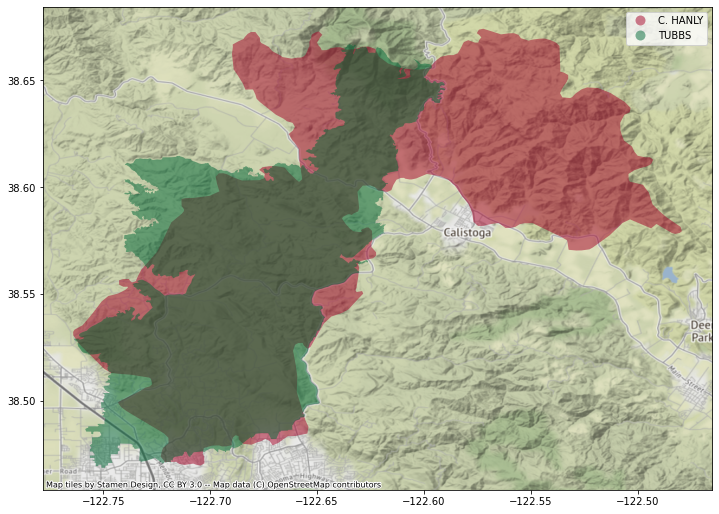

In [24]:
fig, ax = plt.subplots(figsize=(12,12))

fire_gdf.plot(ax=ax, column='attributes.FIRE_NAME', cmap='RdYlGn',legend=True,  alpha=0.5, 
                 legend_kwds={'loc': 'upper right'})

cx.add_basemap(ax, crs=fire_gdf.crs.to_string()
              )



plt.show()

The following map illustrates the overlap of the two fires, as well as plots the housing data for Sonoma County (as of September 2017). 
Certain areas of intereste are identified, such as:
1. The Coffey Park Community, where more than 1300 structures were leveled.
2. Larkfield-Wikiup, where 500 buildings were destroyed
3. The Fountaingrove area, where the Fountaingrove Inn, the historic Fountaingrove Round Barn nearby, and a large Hilton hotel were destroyed; 116 of the 160 units at the Journey's End Mobile Home Park burned to the ground, while the remainder of the park was later red-tagged due to heavy damage.

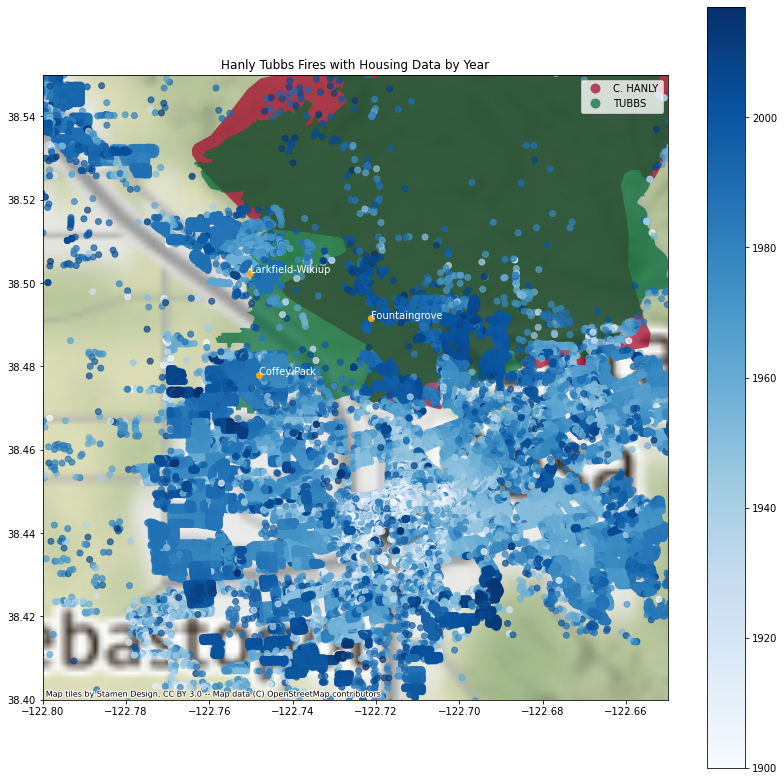

In [25]:
fig, ax = plt.subplots(figsize=(14,14))

fire_gdf.plot(ax=ax, column='attributes.FIRE_NAME', cmap='RdYlGn',legend=True,  alpha=0.7, 
                 legend_kwds={'loc': 'upper right'})

gdf.plot(ax=ax, column='BuildingPrimary:YearBuilt', cmap='Blues',legend=True,  
         alpha=0.7, aspect=1, vmin=1900, vmax=2017)




cx.add_basemap(ax, crs=fire_gdf.crs.to_string())

plt.xlim(-122.8, -122.65)
plt.ylim(38.4, 38.55)


long = [-122.7479789, -122.7502105, -122.7212738]
lat = [38.4780661, 38.5025241, 38.4915694]
locs = ['Coffey Park', 'Larkfield-Wikiup', 'Fountaingrove']

for x, y, name in zip(long, lat, locs):
    plt.scatter(x=x, y=y, c="orange")
    plt.annotate(name, (x, y), c="white")

plt.title("Hanly Tubbs Fires with Housing Data by Year")

plt.show()

### Housing Density Comparison

In [32]:
sjoin = gdf.sjoin(hdf)

ValueError: 'right_df' should be GeoDataFrame, got <class 'pandas.core.frame.DataFrame'>

In [31]:
sjoin.columns

Index(['Unnamed: 0_left', 'ParcelNumber', 'Asmt', 'AsmtClass',
       'TaxabilityDescription', 'TaxRateArea', 'TaxRateAreaDescription',
       'LandDateofLastChange', 'UseCode', 'UseCodeDescription',
       ...
       'statefp10', 'countyfp10', 'tractce10', 'blockce', 'blockid10',
       'housing10', 'pop10', 'shape_length', 'shape_area', 'geom_kk'],
      dtype='object', length=107)

In [41]:

sjoin.groupby(['blockid10', 'housing10'], 
              as_index=False)['BuildingPrimary:YearBuilt'].mean().fillna(0).astype(int).sort_values(by="BuildingPrimary:YearBuilt")


,blockid10,housing10,BuildingPrimary:YearBuilt
1849,60971514021004,21,0
5059,60971541003007,2,0
1313,60971511001011,21,0
1312,60971511001010,2,0
3482,60971530053012,6,0
...,...,...,...
47,60971501003012,2,2014
5038,60971541002009,20,2015
5090,60971541004024,41,2015
4865,60971539021034,1,2016


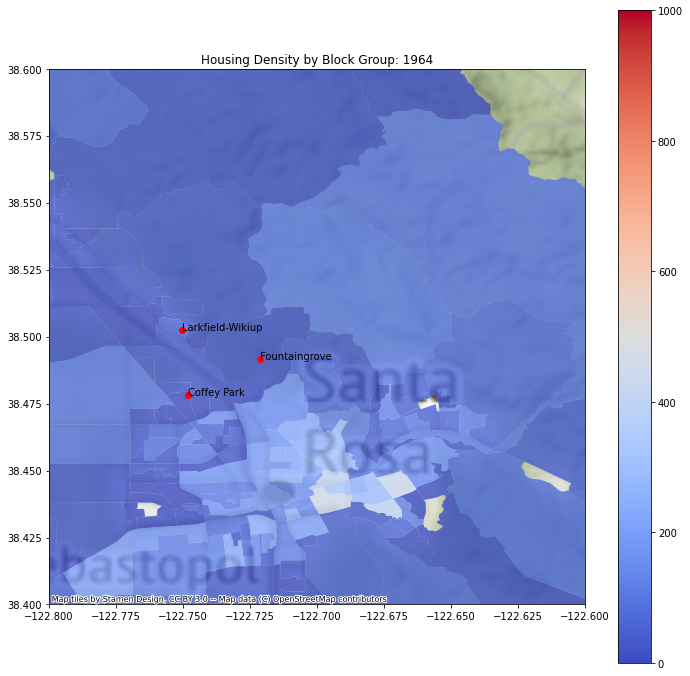

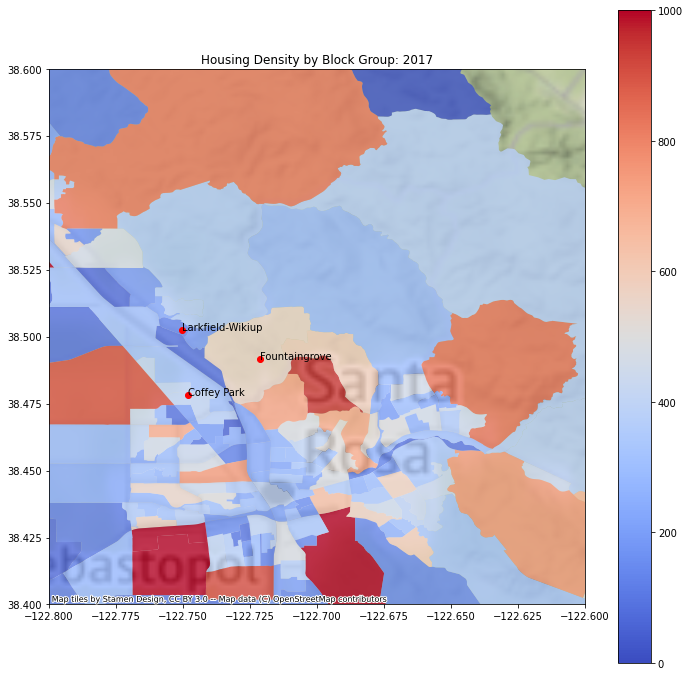

In [26]:
## 1964 Desnity
fig1, ax1 = plt.subplots(figsize=(12,12))

density_1964.plot(column="ParcelNumber",cmap='coolwarm', ax=ax1
                   ,legend=True, figsize=(10,10), vmin=0, vmax=1000, alpha=0.8
                  )

cx.add_basemap(ax1, crs=fire_gdf.crs.to_string()
              )

long = [-122.7479789, -122.7502105, -122.7212738]
lat = [38.4780661, 38.5025241, 38.4915694]
locs = ['Coffey Park', 'Larkfield-Wikiup', 'Fountaingrove']

for x, y, name in zip(long, lat, locs):
    plt.scatter(x=x, y=y, c="red")
    plt.annotate(name, (x, y), c="black")

plt.xlim(-122.8, -122.6)
plt.ylim(38.4, 38.6)
plt.title("Housing Density by Block Group: 1964")
plt.show()


## 2017 Density
fig2, ax2 = plt.subplots(figsize=(12,12))

block_density.plot(column="ParcelNumber",cmap='coolwarm', ax=ax2
                   ,legend=True, figsize=(10,10), vmin=0, vmax=1000, alpha=0.8
                  )

cx.add_basemap(ax2, crs=fire_gdf.crs.to_string()
              )

long = [-122.7479789, -122.7502105, -122.7212738]
lat = [38.4780661, 38.5025241, 38.4915694]
locs = ['Coffey Park', 'Larkfield-Wikiup', 'Fountaingrove']

for x, y, name in zip(long, lat, locs):
    plt.scatter(x=x, y=y, c="red")
    plt.annotate(name, (x, y), c="black")

plt.xlim(-122.8, -122.6)
plt.ylim(38.4, 38.6)
plt.title('Housing Density by Block Group: 2017')

plt.show()

### Visualizaing Weather Comparison Data

In [27]:
display(widgets.interact(update_plot, Variable=Variable))

interactive(children=(Select(description='Feature', layout=Layout(height='200px', width='400px'), options=('Ne…

<function __main__.update_plot(Variable)>